## Goal
The goal of this analysis is to develop a generalized model to deal with (big and imbalanced) data prediction thats suitable for real-world applications.


### Data

The data of this project can be downloaded from [here](https://www.kaggle.com/datasets/ealaxi/paysim1/data).

Data:

**One row**: 1,PAYMENT,1060.31,C429214117,1089.0,28.69,M1591654462,0.0,0.0,0,0

**Headers with column definitions**: 

* step - maps a unit of time in the real world. In this case 1 step is 1 hour of time. Total steps 744 (30 days simulation).

* type - CASH-IN, CASH-OUT, DEBIT, PAYMENT and TRANSFER.

* amount - amount of the transaction in local currency.

* nameOrig - customer who started the transaction

* oldbalanceOrg - initial balance before the transaction

* newbalanceOrig - new balance after the transaction

* nameDest - customer who is the recipient of the transaction

* oldbalanceDest - initial balance recipient before the transaction. Note that there is not information for customers that start with M (Merchants).

* newbalanceDest - new balance recipient after the transaction. Note that there is not information for customers that start with M (Merchants).

* isFraud - This is the transactions made by the fraudulent agents inside the simulation. In this specific dataset the fraudulent behavior of the agents aims to profit by taking control or customers accounts and try to empty the funds by transferring to another account and then cashing out of the system.

* isFlaggedFraud - The business model aims to control massive transfers from one account to another and flags illegal attempts. An illegal attempt in this dataset is an attempt to transfer more than 200,000 in a single transaction.


The structure of the notebook is borrowed from [here](https://www.kaggle.com/arjunjoshua/predicting-fraud-in-financial-payment-services) where they used pandas and sklearn to conduct the fraud detection. 

## Setup




In [1]:
!pip install findspark
import findspark
findspark.init()
findspark.find()
import pyspark

In [2]:
from pyspark import SparkContext, SparkConf
from pyspark.sql import SQLContext

from pyspark.sql.functions import udf
from pyspark.sql.types import StringType
import pyspark.sql.functions as F

In [4]:
conda install openjdk

Solving environment: ...working... done

## Package Plan ##

  environment location: C:\Users\tcfoo\anaconda3

  added / updated specs:
    - openjdk


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    openjdk-11.0.13            |       h2bbff1b_0       301.3 MB
    ------------------------------------------------------------
                                           Total:       301.3 MB

The following NEW packages will be INSTALLED:

  openjdk            pkgs/main/win-64::openjdk-11.0.13-h2bbff1b_0




openjdk-11.0.13      | 301.3 MB  |            |   0% 
openjdk-11.0.13      | 301.3 MB  |            |   0% 
openjdk-11.0.13      | 301.3 MB  |            |   0% 
openjdk-11.0.13      | 301.3 MB  | 1          |   1% 
openjdk-11.0.13      | 301.3 MB  | 1          |   2% 
openjdk-11.0.13      | 301.3 MB  | 2          |   2% 
openjdk-11.0.13      | 301.3 MB  | 3          |   3% 
openjdk-11.0.



==> WARNING: A newer version of conda exists. <==
  current version: 4.11.0
  latest version: 24.5.0

Please update conda by running

    $ conda update -n base -c defaults conda




## 1 Import data

In [5]:
sc = pyspark.SparkContext(appName="financial_fraud_detection")
sqlc = SQLContext(sc)

C:\Users\tcfoo\anaconda3\lib\site-packages\pyspark\sql\context.py:112: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


In [6]:
## data
data_file = './PS_20174392719_1491204439457_log.csv'

In [7]:
data = sqlc.read.csv(data_file,header = True)

## 2 Data exploration

In [8]:
data.count()

6362620

In [9]:
data.dtypes

[('step', 'string'),
 ('type', 'string'),
 ('amount', 'string'),
 ('nameOrig', 'string'),
 ('oldbalanceOrg', 'string'),
 ('newbalanceOrig', 'string'),
 ('nameDest', 'string'),
 ('oldbalanceDest', 'string'),
 ('newbalanceDest', 'string'),
 ('isFraud', 'string'),
 ('isFlaggedFraud', 'string')]

In [15]:
data.limit(5).toPandas()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.0,C1305486145,181.0,0.0,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.0,C840083671,181.0,0.0,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [16]:
data.groupBy('isFraud').count().show()

+-------+-------+
|isFraud|  count|
+-------+-------+
|      0|6354407|
|      1|   8213|
+-------+-------+



There is a major imbalance in labelled data, hence we use stratified split method in the following operation

In [17]:
### checking for missing values
from pyspark.sql.functions import col,sum
data.select(*(sum(col(c).isNull().cast("int")).alias(c) for c in data.columns)).show()

+----+----+------+--------+-------------+--------------+--------+--------------+--------------+-------+--------------+
|step|type|amount|nameOrig|oldbalanceOrg|newbalanceOrig|nameDest|oldbalanceDest|newbalanceDest|isFraud|isFlaggedFraud|
+----+----+------+--------+-------------+--------------+--------+--------------+--------------+-------+--------------+
|   0|   0|     0|       0|            0|             0|       0|             0|             0|      0|             0|
+----+----+------+--------+-------------+--------------+--------+--------------+--------------+-------+--------------+



### 2.1 Studying the  fraudulent data

In [18]:
data.filter(data['isFraud'] == 1).groupby('type').count().show()

+--------+-----+
|    type|count|
+--------+-----+
|TRANSFER| 4097|
|CASH_OUT| 4116|
+--------+-----+



**Observation**: it looks only type is TRANSFER or CASH_OUT will be fraud.

In [19]:
data.groupby('isFlaggedFraud').count().show()

+--------------+-------+
|isFlaggedFraud|  count|
+--------------+-------+
|             0|6362604|
|             1|     16|
+--------------+-------+



### 2.2 check if  'amount' more than 200,000 will be considered fraudulent as specified in description

In [20]:
data.filter(data['isFlaggedFraud'] == 1).orderBy('amount').show()

+----+--------+----------+-----------+-------------+--------------+-----------+--------------+--------------+-------+--------------+
|step|    type|    amount|   nameOrig|oldbalanceOrg|newbalanceOrig|   nameDest|oldbalanceDest|newbalanceDest|isFraud|isFlaggedFraud|
+----+--------+----------+-----------+-------------+--------------+-----------+--------------+--------------+-------+--------------+
| 646|TRANSFER|     1.0E7|  C19004745|1.039904508E7| 1.039904508E7|C1806199534|           0.0|           0.0|      1|             1|
| 425|TRANSFER|     1.0E7| C689608084|1.958504037E7| 1.958504037E7|C1392803603|           0.0|           0.0|      1|             1|
| 730|TRANSFER|     1.0E7|C2140038573|1.731625505E7| 1.731625505E7|C1395467927|           0.0|           0.0|      1|             1|
| 250|TRANSFER|1343002.08|C1100582606|   1343002.08|    1343002.08|C1147517658|           0.0|           0.0|      1|             1|
| 617|TRANSFER|2542664.27| C786455622|   2542664.27|    2542664.27| C

### Getting min and max transaction amount values when it's flagged as fraud

In [21]:
max1 = data.filter(data['isFlaggedFraud'] == 1).agg({"amount": "max"}).collect()[0]
min1 = data.filter(data['isFlaggedFraud'] == 1).agg({"amount": "min"}).collect()[0]

In [22]:
max1 = data.filter(data['isFlaggedFraud'] == 1).agg({"amount": "mean"}).collect()[0]

In [24]:
data.groupBy(['isFlaggedFraud']).agg({'amount':'avg'}).show()

+--------------+------------------+
|isFlaggedFraud|       avg(amount)|
+--------------+------------------+
|             0|179850.13041768514|
|             1|    4861597.730625|
+--------------+------------------+



### Multiple columns and multiple functions

In [26]:
from pyspark.sql.functions import mean, sum, max, col,count
groupBy = ["isFlaggedFraud"]
aggregate = ["amount"] 
funcs = [mean, sum, max,count]

exprs = [f(col(c)) for f in funcs for c in aggregate]

In [33]:
df_1= data.groupby(*groupBy).agg(*exprs).collect()

In [34]:
df_1

[Row(isFlaggedFraud='0', avg(amount)=179850.13041768526, sum(amount)=1144315159196.086, max(amount)='99999.81', count(amount)=6362604),
 Row(isFlaggedFraud='1', avg(amount)=4861597.730625, sum(amount)=77785563.69, max(amount)='9585040.37', count(amount)=16)]

In [35]:
max0 = data.filter(data['isFlaggedFraud'] == 0).agg({"amount": "max"}).collect()[0]
min0 = data.filter(data['isFlaggedFraud'] == 0).agg({"amount": "min"}).collect()[0]

In [36]:
max1[0],min1[0],max0[0],min0[0]

(4861597.730625, '1.0E7', '99999.81', '0.0')

**Observations**: Once transaction is flagged as fraud, the destination's account balance always zero before and after transaction. It made sense as the transcation will be halted when it's flagged as fraud.

In [37]:
data.filter( (data['isFlaggedFraud'] == 0) & (data['oldbalanceDest'] ==0) & (data['newbalanceDest'] ==0)).show(5)

+----+--------+--------+-----------+-------------+--------------+-----------+--------------+--------------+-------+--------------+
|step|    type|  amount|   nameOrig|oldbalanceOrg|newbalanceOrig|   nameDest|oldbalanceDest|newbalanceDest|isFraud|isFlaggedFraud|
+----+--------+--------+-----------+-------------+--------------+-----------+--------------+--------------+-------+--------------+
|   1| PAYMENT| 9839.64|C1231006815|     170136.0|     160296.36|M1979787155|           0.0|           0.0|      0|             0|
|   1| PAYMENT| 1864.28|C1666544295|      21249.0|      19384.72|M2044282225|           0.0|           0.0|      0|             0|
|   1|TRANSFER|   181.0|C1305486145|        181.0|           0.0| C553264065|           0.0|           0.0|      1|             0|
|   1| PAYMENT|11668.14|C2048537720|      41554.0|      29885.86|M1230701703|           0.0|           0.0|      0|             0|
|   1| PAYMENT| 7817.71|  C90045638|      53860.0|      46042.29| M573487274|      

In [38]:
### whether flagged fraud accounts have duplicate account names
data.filter(data['isFlaggedFraud'] == 1).groupBy('nameOrig').count().show()

+-----------+-----+
|   nameOrig|count|
+-----------+-----+
| C728984460|    1|
|C1100582606|    1|
|C1035541766|    1|
| C908544136|    1|
| C452586515|    1|
| C689608084|    1|
|C2140038573|    1|
|C1684585475|    1|
| C917414431|    1|
| C724693370|    1|
| C992223106|    1|
|C1869569059|    1|
|  C19004745|    1|
| C193696150|    1|
| C786455622|    1|
|C1892216157|    1|
+-----------+-----+



In [39]:
data.filter(data['isFlaggedFraud'] == 1).groupBy('nameDest').count().show()

+-----------+-----+
|   nameDest|count|
+-----------+-----+
| C639921569|    1|
|C1147517658|    1|
|C1100697970|    1|
| C891140444|    1|
|C1392803603|    1|
|C1109166882|    1|
|C1806199534|    1|
|C1861208726|    1|
|C1395467927|    1|
| C661958277|    1|
| C484597480|    1|
|C1909486199|    1|
|C1082139865|    1|
|C1770418982|    1|
|C1308068787|    1|
|C1366804249|    1|
+-----------+-----+



### 2.3. Are expected merchant accounts accordingly labelled?
It was stated <a href='http://www2.bth.se/com/edl.nsf/pages/phd-dissertation'>[5]</a> that CASH_IN involves being paid by
a merchant (whose name is prefixed by 'M'). However, as shown below, the present data does not have
merchants making CASH_IN transactions to customers.

In [40]:
subd1 = data.filter( (data['type'] == 'CASH_IN') & \
                (data['nameOrig'].like('%M%')) ).show(4)

+----+----+------+--------+-------------+--------------+--------+--------------+--------------+-------+--------------+
|step|type|amount|nameOrig|oldbalanceOrg|newbalanceOrig|nameDest|oldbalanceDest|newbalanceDest|isFraud|isFlaggedFraud|
+----+----+------+--------+-------------+--------------+--------+--------------+--------------+-------+--------------+
+----+----+------+--------+-------------+--------------+--------+--------------+--------------+-------+--------------+



In [41]:
subd1 = data.filter( (data['type'] == 'CASH_OUT') & \
                (data['nameOrig'].like('%M%')) ).show(4)

+----+----+------+--------+-------------+--------------+--------+--------------+--------------+-------+--------------+
|step|type|amount|nameOrig|oldbalanceOrg|newbalanceOrig|nameDest|oldbalanceDest|newbalanceDest|isFraud|isFlaggedFraud|
+----+----+------+--------+-------------+--------------+--------+--------------+--------------+-------+--------------+
+----+----+------+--------+-------------+--------------+--------+--------------+--------------+-------+--------------+



In [42]:
data.filter(data['nameDest'].like('%M%')).groupBy('type').count().show()

+-------+-------+
|   type|  count|
+-------+-------+
|PAYMENT|2151495|
+-------+-------+



In [43]:
data.filter( (col('nameDest').isin(col('nameOrig'))) & (data['isFraud'] == 1)).show(5)

+----+----+------+--------+-------------+--------------+--------+--------------+--------------+-------+--------------+
|step|type|amount|nameOrig|oldbalanceOrg|newbalanceOrig|nameDest|oldbalanceDest|newbalanceDest|isFraud|isFlaggedFraud|
+----+----+------+--------+-------------+--------------+--------+--------------+--------------+-------+--------------+
+----+----+------+--------+-------------+--------------+--------+--------------+--------------+-------+--------------+



### Names of Fraud and not Fraud

In [44]:
df1 = data.filter(data['isFraud'] == 1) ## fraud
df0 = data.filter(data['isFraud'] == 0) ## not fraud

In [45]:
##Get the unique names if the data is fraud
unique_org_names1 = [i.nameOrig for i in df1.select('nameOrig').distinct().collect()]
unique_org_names0 = [i.nameOrig for i in df0.select('nameOrig').distinct().collect()]

Could destination accounts for fraudulent TRANSFERs originate CASHOUTs that
are not detected and are labeled as genuine? It turns out there are  3 such
accounts.

### Faster way to filter when the number of filter is big
It looks didn't work when we join them together

In [ ]:
subd = df1.join(F.broadcast(list_filter_df),df1.columns[6:7])

## 3 Data cleaning

In [56]:
dta = data.filter(data['type'].isin(['CASH_OUT','TRANSFER'])) #because only these two types have fraudulent transactions

##### Destination account - replace zero with -1

In [58]:
### change  0 values to more sensible values for some cases
from pyspark.sql.functions import when
import numpy as np

dta = dta.withColumn('oldbalanceDest', \
              when((dta['oldbalanceDest'] == 0) & (dta['newbalanceDest'] ==0) & (dta['amount'] !=0), -1).otherwise(dta['oldbalanceDest']))

dta = dta.withColumn('newbalanceDest', \
              when((dta['oldbalanceDest'] == 0) & (dta['newbalanceDest'] ==0) & (dta['amount'] !=0), -1).otherwise(dta['newbalanceDest']))

In [59]:
##check if the replacement worked
dta.agg({"oldbalanceDest": "min"}).collect()[0]

Row(min(oldbalanceDest)='-1')

#### Convert string to numeric columns

In [60]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer
'''dta is the filtered data frame'''
indexers = [StringIndexer(inputCol=column, outputCol=column+"_index").fit(x0) for column in ['type'] ]

pipeline = Pipeline(stages=indexers)
x_r = pipeline.fit(dta).transform(dta)

In [61]:
x_r.limit(5).toPandas()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,type_index
0,1,TRANSFER,181.0,C1305486145,181.0,0.0,C553264065,-1,0.0,1,0,1.0
1,1,CASH_OUT,181.0,C840083671,181.0,0.0,C38997010,21182.0,0.0,1,0,0.0
2,1,CASH_OUT,229133.94,C905080434,15325.0,0.0,C476402209,5083.0,51513.44,0,0,0.0
3,1,TRANSFER,215310.3,C1670993182,705.0,0.0,C1100439041,22425.0,0.0,0,0,1.0
4,1,TRANSFER,311685.89,C1984094095,10835.0,0.0,C932583850,6267.0,2719172.89,0,0,1.0


In [62]:
from pyspark.sql.types import IntegerType

In [63]:
xx = x_r.withColumn('type_index',x_r['type_index'].cast(IntegerType()))
xx = xx.withColumn('isFraud',x_r['isFraud'].cast(IntegerType()))

In [64]:
xx = xx.withColumnRenamed('isFraud','label')

In [65]:
xx.limit(5).toPandas()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,label,isFlaggedFraud,type_index
0,1,TRANSFER,181.0,C1305486145,181.0,0.0,C553264065,-1,0.0,1,0,1
1,1,CASH_OUT,181.0,C840083671,181.0,0.0,C38997010,21182.0,0.0,1,0,0
2,1,CASH_OUT,229133.94,C905080434,15325.0,0.0,C476402209,5083.0,51513.44,0,0,0
3,1,TRANSFER,215310.3,C1670993182,705.0,0.0,C1100439041,22425.0,0.0,0,0,1
4,1,TRANSFER,311685.89,C1984094095,10835.0,0.0,C932583850,6267.0,2719172.89,0,0,1


In [66]:
xf = xx.drop('type')

In [67]:
xf.limit(5).toPandas()

,step,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,label,isFlaggedFraud,type_index
0,1,181.0,C1305486145,181.0,0.0,C553264065,-1,0.0,1,0,1
1,1,181.0,C840083671,181.0,0.0,C38997010,21182.0,0.0,1,0,0
2,1,229133.94,C905080434,15325.0,0.0,C476402209,5083.0,51513.44,0,0,0
3,1,215310.3,C1670993182,705.0,0.0,C1100439041,22425.0,0.0,0,0,1
4,1,311685.89,C1984094095,10835.0,0.0,C932583850,6267.0,2719172.89,0,0,1


## 4 Feature enginering

In [68]:
from pyspark.sql.functions import col

In [69]:
xf = xf.withColumn("errorbalanceOrig", col("newbalanceOrig") + col("amount") - col("oldbalanceOrg")) #new feature error_balance

In [70]:
xf = xf.withColumn("errorbalanceDest", col("oldbalanceDest") + col("amount") - col("newbalanceDest"))

In [71]:
xf.limit(5).toPandas()

,step,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,label,isFlaggedFraud,type_index,errorbalanceOrig,errorbalanceDest
0,1,181.0,C1305486145,181.0,0.0,C553264065,-1,0.0,1,0,1,0.00,180.0
1,1,181.0,C840083671,181.0,0.0,C38997010,21182.0,0.0,1,0,0,0.00,21363.0
2,1,229133.94,C905080434,15325.0,0.0,C476402209,5083.0,51513.44,0,0,0,213808.94,182703.5
3,1,215310.3,C1670993182,705.0,0.0,C1100439041,22425.0,0.0,0,0,1,214605.30,237735.3
4,1,311685.89,C1984094095,10835.0,0.0,C932583850,6267.0,2719172.89,0,0,1,300850.89,-2401220.0


## convert data frame types

In [72]:
xf.dtypes

[('step', 'string'),
 ('amount', 'string'),
 ('nameOrig', 'string'),
 ('oldbalanceOrg', 'string'),
 ('newbalanceOrig', 'string'),
 ('nameDest', 'string'),
 ('oldbalanceDest', 'string'),
 ('newbalanceDest', 'string'),
 ('label', 'int'),
 ('isFlaggedFraud', 'string'),
 ('type_index', 'int'),
 ('errorbalanceOrig', 'double'),
 ('errorbalanceDest', 'double')]

In [73]:
sxv = ['step',
      'amount','oldbalanceOrg','newbalanceOrig',
      'oldbalanceDest','newbalanceDest']
for col_name in sxv:
    xf = xf.withColumn(col_name, col(col_name).cast('float'))

In [74]:
xf.dtypes

[('step', 'float'),
 ('amount', 'float'),
 ('nameOrig', 'string'),
 ('oldbalanceOrg', 'float'),
 ('newbalanceOrig', 'float'),
 ('nameDest', 'string'),
 ('oldbalanceDest', 'float'),
 ('newbalanceDest', 'float'),
 ('label', 'int'),
 ('isFlaggedFraud', 'string'),
 ('type_index', 'int'),
 ('errorbalanceOrig', 'double'),
 ('errorbalanceDest', 'double')]

## 5 Train and test data split

In [75]:
from pyspark.sql.functions import lit

### stratified split

Using stratified split instead of random split  can overcome the imbalance in data problem.

In [77]:
fractions = xf.select("label").distinct().withColumn("fraction", lit(0.8)).rdd.collectAsMap()
df_train = xf.sampleBy('label',fractions,seed=17)
df_test = xf.subtract(df_train)

## 6 Model - pipeline

In [78]:
yv = ['label']
xv = ['step','type_index','amount','oldbalanceOrg','newbalanceOrig',
      'oldbalanceDest','newbalanceDest',"errorbalanceOrig","errorbalanceDest"]

### 6.1 convert dataframe to vector

In [79]:
from pyspark.ml.feature import VectorAssembler

vecAssembler = VectorAssembler(inputCols= xv, outputCol="va")

In [80]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler

from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.tuning import CrossValidator,  TrainValidationSplit, ParamGridBuilder
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

### 6.2 Creating PCA (reducing features)

In [81]:
from pyspark.ml.feature import PCA

pca = PCA(k=5, inputCol="va", outputCol="features")

### 6.3 Creating a RandomForest classifier

In [82]:
from pyspark.ml.classification import RandomForestClassifier

rf = RandomForestClassifier(labelCol="label", featuresCol="features")

### 6.4 Creating a Multiclass Classification Evaluator

In [83]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

evaluator = MulticlassClassificationEvaluator()  

### Creating  a Pipeline

This will be easier when we need to test different scenarios.

In [84]:
from pyspark.ml import Pipeline

pipeline = Pipeline(stages=[vecAssembler, pca, rf])

## 7 Hyperparameter tunning

### Through Grid Search Configuration 

In [87]:
from pyspark.ml.tuning import CrossValidator, TrainValidationSplit, ParamGridBuilder

#model will be tested using values in the specified ranges to choose optinum hyperparameter values 
paramGrid = (ParamGridBuilder()
             .addGrid(rf.maxDepth, [2, 4, 6])
             .addGrid(rf.maxBins, [20, 60])
             .addGrid(rf.numTrees, [5, 20])
             .addGrid(rf.impurity, ['gini', 'entropy'])
             .build())

def get_validation(by='cv'):
    if by is 'cv': ##cross validation
        return CrossValidator(
            estimator=pipeline,
            estimatorParamMaps=paramGrid,
            evaluator=evaluator,
            numFolds=10)
    
    elif by is 'tvs': ##train and test split
        return TrainValidationSplit(
            estimator=pipeline,
            estimatorParamMaps=paramGrid,
            evaluator=evaluator,
            # 75% of the data will be used for training, 20% for validation.
            trainRatio=0.75)
    else:
        print('please, pick either cv or tvs')
        return None
    
def evaluate(model, df_train, df_test):
    train_pred = model.transform(df_train)
    train_acc = evaluator.evaluate(train_pred)
    
    test_pred = model.transform(df_test)
    test_acc = evaluator.evaluate(test_pred)
    
    print('train_acc: {}, test_acc: {}'.format(train_acc, test_acc))
    
    return train_pred, test_pred

<>:12: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:19: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:12: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:19: SyntaxWarning: "is" with a literal. Did you mean "=="?
<ipython-input-87-b66992bacefb>:12: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if by is 'cv': ##cross validation
<ipython-input-87-b66992bacefb>:19: SyntaxWarning: "is" with a literal. Did you mean "=="?
  elif by is 'tvs': ##train and test split


In [88]:
df_train.dtypes

[('step', 'float'),
 ('amount', 'float'),
 ('nameOrig', 'string'),
 ('oldbalanceOrg', 'float'),
 ('newbalanceOrig', 'float'),
 ('nameDest', 'string'),
 ('oldbalanceDest', 'float'),
 ('newbalanceDest', 'float'),
 ('label', 'int'),
 ('isFlaggedFraud', 'string'),
 ('type_index', 'int'),
 ('errorbalanceOrig', 'double'),
 ('errorbalanceDest', 'double')]

In [89]:
val = get_validation('cv')
model_cv = val.fit(df_train)

## Best model

In [90]:

bestModel = model_cv.bestModel
finalPredictions = bestModel.transform(df_train)
evaluator.evaluate(finalPredictions)

0.998162855678161

### Best hyperparameter values

In [91]:
bestModel.stages[-1]._java_obj.getImpurity()

'gini'

In [92]:
bestModel.stages[-1]._java_obj.getMaxDepth()

6

In [93]:
bestModel.stages[-1]._java_obj.getMaxBins()

60

In [94]:
bestModel.stages[-1]._java_obj.getNumTrees()

20

## Evalution of Model - Accuracy

In [95]:
train_pred, test_pred = evaluate(model_cv, df_train, df_test)

train_acc: 0.998162855678161, test_acc: 0.9982688222964411


## Plotting a confusion matrix to evaluate model and calculate precision & recall

In [96]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('ggplot')

from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import classification_report

class Util:
        
    def report_classification(model, df_train, df_test, X_features, y_feature):
        
        classes_train = np.unique(df_train[y_feature].values).tolist()
        classes_test = np.unique(df_test[y_feature].values).tolist()
        
        assert (classes_train == classes_test)
        
        classes = classes_train # The order of class is important!
        
        X_train = df_train[X_features].values.tolist()
        X_test = df_test[X_features].values.tolist()
        
        y_train = df_train[y_feature].values.tolist()
        y_test = df_test[y_feature].values.tolist()
        
        y_train_pred = model.predict(X_train)
        y_test_pred = model.predict(X_test)

        report_cm(y_train, y_test, y_train_pred, y_test_pred, classes)
        
    def report_cm(y_train, y_test, y_train_pred, y_test_pred, classes):
        figure, axes = plt.subplots(1, 2, figsize=(10,5))

        cm_test = confusion_matrix(y_test, y_test_pred)
        df_cm_test = pd.DataFrame(cm_test, index = classes, columns = classes)
        ax = sns.heatmap(df_cm_test, annot=True, ax = axes[0], square= True)
        ax.set_title('Test CM')

        cm_train = confusion_matrix(y_train, y_train_pred)
        df_cm_train = pd.DataFrame(cm_train, index = classes, columns = classes)
        ax = sns.heatmap(df_cm_train, annot=True, ax = axes[1], square= True)
        ax.set_title('Train CM')

        print('-' * 20 + 'Testing Performance' + '-' * 20)
        print(classification_report(y_test, y_test_pred, target_names = classes))
        print('acc: ', metrics.accuracy_score(y_test, y_test_pred))

        print('-' * 20 + 'Training Performance' + '-' * 20)
        print(classification_report(y_train, y_train_pred, target_names = classes))
        print('acc: ', metrics.accuracy_score(y_train, y_train_pred))

--------------------Testing Performance--------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    553228
           1       0.92      0.53      0.67      1630

    accuracy                           1.00    554858
   macro avg       0.96      0.76      0.83    554858
weighted avg       1.00      1.00      1.00    554858

acc:  0.9984752855685599
--------------------Training Performance--------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   2208968
           1       0.92      0.50      0.65      6583

    accuracy                           1.00   2215551
   macro avg       0.96      0.75      0.83   2215551
weighted avg       1.00      1.00      1.00   2215551

acc:  0.9983990438495887


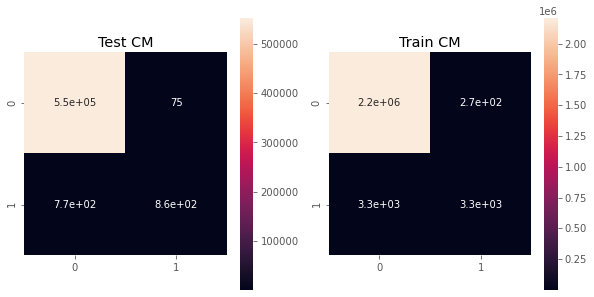

In [97]:
y_train = train_pred.select('label').toPandas().apply(lambda x : x[0], 1).values.tolist()
y_train_pred = train_pred.select('prediction').toPandas().apply(lambda x : x[0], 1).values.tolist()

y_test = test_pred.select('label').toPandas().apply(lambda x : x[0], 1).values.tolist()
y_train_test = test_pred.select('prediction').toPandas().apply(lambda x : x[0], 1).values.tolist()

Util.report_cm(y_train, y_test, y_train_pred, y_train_test, ['0', '1'])

In [98]:
selected = train_pred.select("label", "prediction", "probability")
display(selected.show(10))

+-----+----------+--------------------+
|label|prediction|         probability|
+-----+----------+--------------------+
|    1|       0.0|[0.98998075652132...|
|    0|       0.0|[0.99957235695778...|
|    0|       0.0|[0.99957235695778...|
|    0|       0.0|[0.99905749952578...|
|    0|       0.0|[0.99957235695778...|
|    0|       0.0|[0.99859046498619...|
|    0|       0.0|[0.84615682137752...|
|    0|       0.0|[0.74673689865889...|
|    0|       0.0|[0.99957235695778...|
|    0|       0.0|[0.99853684220515...|
+-----+----------+--------------------+
only showing top 10 rows



None